In [234]:
import numpy as np
import pandas as pd

from utils import preprocess
import model
from model.cnn import OlidCnnNet, OlidCnnAdvance
from utils import plotutils
from utils import trainutils

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [235]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))

Available device: cuda:0


In [237]:
DATA_DIR = "./data/"
TRAIN_DATA_FILE = DATA_DIR + "olid-training-v1.0.tsv"
TEST_A_DATA_FILE = DATA_DIR + "testset-levela.tsv"
LABEL_A_DATA_FILE = DATA_DIR + "labels-levela.csv"
TEST_B_DATA_FILE = DATA_DIR + "testset-levelb.tsv"
LABEL_B_DATA_FILE = DATA_DIR + "labels-levelb.csv"
TEST_C_DATA_FILE = DATA_DIR + "testset-levelc.tsv"
LABEL_C_DATA_FILE = DATA_DIR + "labels-levelc.csv"

ori_train_data = pd.read_csv(TRAIN_DATA_FILE, sep='\t')

task_a_test_data = pd.read_csv(TEST_A_DATA_FILE, sep='\t')
task_a_test_label = pd.read_csv(LABEL_A_DATA_FILE, usecols=[1], names=['labela'])

task_b_test_data = pd.read_csv(TEST_B_DATA_FILE, sep='\t')
task_b_test_label = pd.read_csv(LABEL_B_DATA_FILE, usecols=[1], names=['labelb'])

task_c_test_data = pd.read_csv(TEST_C_DATA_FILE, sep='\t')
task_c_test_label = pd.read_csv(LABEL_C_DATA_FILE, usecols=[1], names=['labelc'])

In [238]:
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from spacy.lang.en import stop_words
from string import punctuation
import emoji

## TASK A

#### Preprocess A

In [239]:
tweets_train = ori_train_data["tweet"].tolist()
tweets_test_a = task_a_test_data["tweet"].tolist()

Train data preprocess

In [240]:
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweets_train]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)

vocabulary, documents_padded = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=20000, num_tokens=100)

#### Word Embedding A

In [241]:
vocabulary, documents_vector = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=20000, padded=False)
pretrained_embedding = preprocess.get_embedding_from_torch_text(vocabulary, "twitter.27B", 200)

#### Create Dataset A

In [242]:
label2id = {'NOT': 0, 'OFF': 1}
sub_a_label_train = ori_train_data['subtask_a'].map(label2id).to_list()
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_padded, sub_a_label_train, test_size=0.2, random_state=5246)

In [243]:
train_dataset = TensorDataset(sentences_train, torch.tensor(labels_train))
test_dataset = TensorDataset(sentences_test, torch.tensor(labels_test))

In [244]:
batch_size = 512

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### Train A

In [245]:
params = {
    "seq_len": documents_padded.size(1),
    "in_channels": 1,
    "vocab_size": pretrained_embedding.shape[0],
    "embed_size": pretrained_embedding.shape[1],
    "conv_kernel_sizes": [1,2,3,4,5],
    "out_channels": 100,
    "conv_stride": 1,
    "conv_padding": 1,
    "maxpool_kernel_size": 70,
    "maxpool_padding": 0,
    "linear_sizes": [100],
    "linear_dropout": 0.5,
    "output_size": 2
}

# Define model paramaters
params = trainutils.Dict2Class(params)
# Create model  
cnn = OlidCnnAdvance(params).to(device)

# Load pretrained word embedding
cnn.embedding.weight.data = pretrained_embedding.to(device)
cnn.embedding.weight.requires_grad = False

# Define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
# Define loss function
criterion = nn.NLLLoss()
print(cnn)

OlidCnnAdvance(
  (embedding): Embedding(19032, 200)
  (conv_layers): ModuleDict(
    (conv_1): Conv2d(1, 100, kernel_size=(1, 200), stride=(1, 1), padding=(1, 0))
    (conv_2): Conv2d(1, 100, kernel_size=(2, 200), stride=(1, 1), padding=(1, 0))
    (conv_3): Conv2d(1, 100, kernel_size=(3, 200), stride=(1, 1), padding=(1, 0))
    (conv_4): Conv2d(1, 100, kernel_size=(4, 200), stride=(1, 1), padding=(1, 0))
    (conv_5): Conv2d(1, 100, kernel_size=(5, 200), stride=(1, 1), padding=(1, 0))
  )
  (maxpool_layers): ModuleDict(
    (maxpool_1): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_2): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_3): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_4): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_5): MaxPool2d(kernel_size=(1, 70), stride=(

[Epoch 50] loss: 0.121,	 F1 train: 0.999,	 F1 test: 0.769,	 Best epoch: 08
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1750
           1       0.73      0.59      0.65       898

    accuracy                           0.79      2648
   macro avg       0.77      0.74      0.75      2648
weighted avg       0.78      0.79      0.78      2648

Best F1 score: 0.7874
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1750
           1       0.73      0.59      0.65       898

    accuracy                           0.79      2648
   macro avg       0.77      0.74      0.75      2648
weighted avg       0.78      0.79      0.78      2648



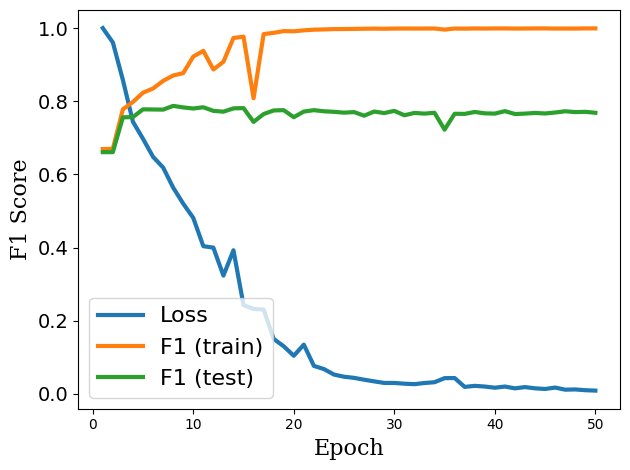

In [246]:
cnn.to(device)
epochs = 30
#trainutils.evaluate(cnn, test_dataloader, device)
results, best_model, best_f1, best_report = trainutils.train(cnn, train_dataloader, test_dataloader, optimizer, criterion, epochs, device, verbose=True)
print(f"Best F1 score: {best_f1:.4f}")
print(best_report)
plotutils.plot_training_results(results)

### Task A Evaluation

In [247]:
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweets_test_a]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)

documents_padded = preprocess.get_vector_from_vocabulary(vocabulary, tokenized_tweet_list,  padded=True, num_tokens=100)

sub_a_label_test = task_a_test_label['labela'].map(label2id).to_list()
print(sub_a_label_test)
test_a_dataset = TensorDataset(documents_padded, torch.tensor(sub_a_label_test))
test_a_dataloader = DataLoader(test_a_dataset, batch_size=batch_size, shuffle=True)

[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 

In [248]:
cnn.load_state_dict(best_model)
f1_a, report_a = trainutils.evaluate(cnn, test_a_dataloader, device)
print(f1_a)
print(report_a)

0.8023255813953488
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       620
           1       0.68      0.54      0.60       240

    accuracy                           0.80       860
   macro avg       0.76      0.72      0.74       860
weighted avg       0.79      0.80      0.79       860



## TASK B

#### Preprocess B

In [249]:
tweets_b_train = ori_train_data[ori_train_data["subtask_a"] == "OFF"]["tweet"].to_list()
#tweets_b_test = task_b_test_data["tweet"].tolist()

In [250]:
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweets_b_train]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)
vocabulary, documents_padded = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=10000, num_tokens=70)

#### Word Embedding B

In [251]:
vocabulary, documents_vector = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=10000, padded=False)
pretrained_embedding = preprocess.get_embedding_from_torch_text(vocabulary, "twitter.27B", 200)

#### Train B

In [252]:
label2id = {'UNT': 0, 'TIN': 1}
sub_b_label_train = ori_train_data[ori_train_data["subtask_a"] == "OFF"]["subtask_b"].map(label2id).to_list()
#sub_b_label_test = task_b_test_label['labelb'].map(label2id).to_list()
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_padded, sub_b_label_train, test_size=0.2, random_state=5246)

In [253]:
train_dataset = TensorDataset(sentences_train, torch.tensor(labels_train))
test_dataset = TensorDataset(sentences_test, torch.tensor(labels_test))

In [254]:
batch_size = 512

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [255]:
params = {
    "seq_len": documents_padded.size(1),
    "in_channels": 1,
    "vocab_size": pretrained_embedding.shape[0],
    "embed_size": pretrained_embedding.shape[1],
    "conv_kernel_sizes": [2,3,4],
    "out_channels": 10,
    "conv_stride": 1,
    "conv_padding": 1,
    "maxpool_kernel_size": 50,
    "maxpool_padding": 0,
    "linear_sizes": [70],
    "linear_dropout": 0.5,
    "output_size": 2
}

# Define model paramaters
params = trainutils.Dict2Class(params)
# Create model  
cnn = OlidCnnAdvance(params).to(device)

# Load pretrained word embedding
cnn.embedding.weight.data = pretrained_embedding.to(device)
cnn.embedding.weight.requires_grad = False

# Define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
# Define loss function
criterion = nn.NLLLoss()

print(cnn)

OlidCnnAdvance(
  (embedding): Embedding(10004, 200)
  (conv_layers): ModuleDict(
    (conv_2): Conv2d(1, 10, kernel_size=(2, 200), stride=(1, 1), padding=(1, 0))
    (conv_3): Conv2d(1, 10, kernel_size=(3, 200), stride=(1, 1), padding=(1, 0))
    (conv_4): Conv2d(1, 10, kernel_size=(4, 200), stride=(1, 1), padding=(1, 0))
  )
  (maxpool_layers): ModuleDict(
    (maxpool_2): MaxPool2d(kernel_size=(1, 50), stride=(1, 50), padding=0, dilation=1, ceil_mode=False)
    (maxpool_3): MaxPool2d(kernel_size=(1, 50), stride=(1, 50), padding=0, dilation=1, ceil_mode=False)
    (maxpool_4): MaxPool2d(kernel_size=(1, 50), stride=(1, 50), padding=0, dilation=1, ceil_mode=False)
  )
  (linears): ModuleList(
    (0): Linear(in_features=30, out_features=70, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=70, out_features=2, bias=True)
)


c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metr

[Epoch 12] loss: 2.514,	 F1 train: 0.884,	 F1 test: 0.867,	 Best epoch: 01
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.87      1.00      0.93       763

    accuracy                           0.87       880
   macro avg       0.43      0.50      0.46       880
weighted avg       0.75      0.87      0.81       880

No further improvement. Early stop.
Best F1 score: 0.8670
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.87      1.00      0.93       763

    accuracy                           0.87       880
   macro avg       0.43      0.50      0.46       880
weighted avg       0.75      0.87      0.81       880



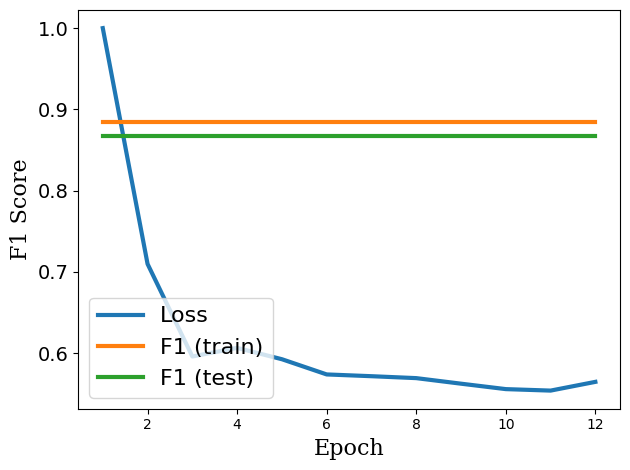

In [256]:
cnn.to(device)
epochs = 50
#trainutils.evaluate(cnn, test_dataloader, device)
results, best_model_b, best_f1, best_report = trainutils.train(cnn, train_dataloader, test_dataloader, optimizer, criterion, epochs, device, verbose=True)
print(f"Best F1 score: {best_f1:.4f}")
print(best_report)
plotutils.plot_training_results(results)

### Task B Evaluation

In [257]:
tweets_test_b = task_b_test_data["tweet"].tolist()
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweets_test_b]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)

documents_padded = preprocess.get_vector_from_vocabulary(vocabulary, tokenized_tweet_list,  padded=True, num_tokens=70)

sub_b_label_test = task_b_test_label['labelb'].map(label2id).to_list()
print(sub_b_label_test)
test_b_dataset = TensorDataset(documents_padded, torch.tensor(sub_b_label_test))
test_b_dataloader = DataLoader(test_b_dataset, batch_size=batch_size, shuffle=True)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [258]:
cnn.load_state_dict(best_model_b)
f1_b, report_b = trainutils.evaluate(cnn, test_b_dataloader, device)
print(f1_b)
print(report_b)

0.8875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.89      1.00      0.94       213

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240



c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TASK C

#### PreProcess C

In [259]:
tweets_c_train = ori_train_data[ori_train_data["subtask_b"] == "TIN"]["tweet"].to_list()
tweets_c_test = task_b_test_data["tweet"].tolist()

In [260]:
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweets_c_train]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)
vocabulary, documents_padded = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=10000, num_tokens=100)

#### Word Embedding C

In [261]:
vocabulary, documents_vector = preprocess.transform_word_to_vector(tokenized_tweet_list, num_vocab=10000, padded=False)
pretrained_embedding = preprocess.get_embedding_from_torch_text(vocabulary, "twitter.27B", 200)

#### Train C

In [262]:
label2id = {'IND': 0, 'GRP': 1, 'OTH': 2}
sub_c_label_train = ori_train_data[ori_train_data["subtask_b"] == "TIN"]["subtask_c"].map(label2id).to_list()
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_padded, sub_c_label_train, test_size=0.2, random_state=5246)

In [263]:
train_dataset = TensorDataset(sentences_train, torch.tensor(labels_train))
test_dataset = TensorDataset(sentences_test, torch.tensor(labels_test))

In [264]:
batch_size = 512

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [265]:
params = {
    "seq_len": documents_padded.size(1),
    "in_channels": 1,
    "vocab_size": pretrained_embedding.shape[0],
    "embed_size": pretrained_embedding.shape[1],
    "conv_kernel_sizes": [1,2,3,4,5],
    "out_channels": 100,
    "conv_stride": 1,
    "conv_padding": 1,
    "maxpool_kernel_size": 70,
    "maxpool_padding": 0,
    "linear_sizes": [100],
    "linear_dropout": 0.5,
    "output_size": 3
}

# Define model paramaters
params = trainutils.Dict2Class(params)
# Create model  
cnn = OlidCnnAdvance(params).to(device)

# Load pretrained word embedding
cnn.embedding.weight.data = pretrained_embedding.to(device)
cnn.embedding.weight.requires_grad = False

# Define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
# Define loss function
criterion = nn.NLLLoss()

print(cnn)

OlidCnnAdvance(
  (embedding): Embedding(9675, 200)
  (conv_layers): ModuleDict(
    (conv_1): Conv2d(1, 100, kernel_size=(1, 200), stride=(1, 1), padding=(1, 0))
    (conv_2): Conv2d(1, 100, kernel_size=(2, 200), stride=(1, 1), padding=(1, 0))
    (conv_3): Conv2d(1, 100, kernel_size=(3, 200), stride=(1, 1), padding=(1, 0))
    (conv_4): Conv2d(1, 100, kernel_size=(4, 200), stride=(1, 1), padding=(1, 0))
    (conv_5): Conv2d(1, 100, kernel_size=(5, 200), stride=(1, 1), padding=(1, 0))
  )
  (maxpool_layers): ModuleDict(
    (maxpool_1): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_2): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_3): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_4): MaxPool2d(kernel_size=(1, 70), stride=(1, 70), padding=0, dilation=1, ceil_mode=False)
    (maxpool_5): MaxPool2d(kernel_size=(1, 70), stride=(1

[Epoch 38] loss: 1.696,	 F1 train: 0.900,	 F1 test: 0.741,	 Best epoch: 27
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       500
           1       0.63      0.69      0.66       203
           2       0.00      0.00      0.00        73

    accuracy                           0.76       776
   macro avg       0.48      0.53      0.50       776
weighted avg       0.69      0.76      0.72       776

No further improvement. Early stop.
Best F1 score: 0.7590
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       500
           1       0.63      0.69      0.66       203
           2       0.00      0.00      0.00        73

    accuracy                           0.76       776
   macro avg       0.48      0.53      0.50       776
weighted avg       0.69      0.76      0.72       776



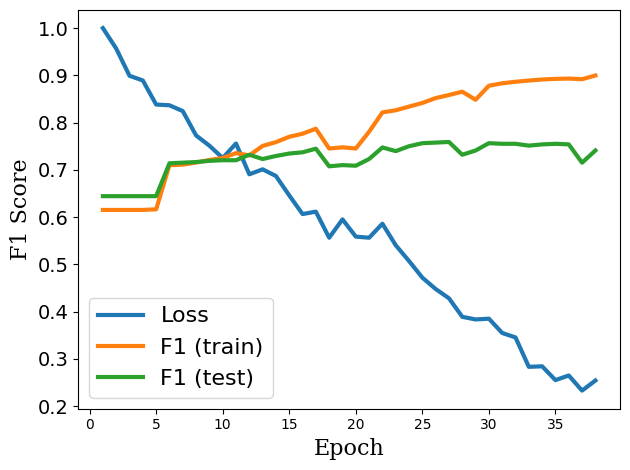

In [266]:
cnn.to(device)
epochs = 50
#trainutils.evaluate(cnn, test_dataloader, device)
results, best_model_c, best_f1, best_report = trainutils.train(cnn, train_dataloader, test_dataloader, optimizer, criterion, epochs, device, verbose=True)
print(f"Best F1 score: {best_f1:.4f}")
print(best_report)
plotutils.plot_training_results(results)

### Task C Evaluation

In [270]:
tweets_test_c = task_c_test_data["tweet"].tolist()
processed_tweet_list = [preprocess.glove_twitter_preprocess(t) for t in tweets_test_c]
tokenized_tweet_list = preprocess.nltk_tokenize(processed_tweet_list)

documents_padded = preprocess.get_vector_from_vocabulary(vocabulary, tokenized_tweet_list,  padded=True, num_tokens=100)

sub_c_label_test = task_c_test_label['labelc'].map(label2id).to_list()
print(sub_c_label_test)
test_c_dataset = TensorDataset(documents_padded, torch.tensor(sub_c_label_test))
test_c_dataloader = DataLoader(test_c_dataset, batch_size=batch_size, shuffle=True)

[2, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 2, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]


In [271]:
cnn.load_state_dict(best_model_c)
f1_c, report_c = trainutils.evaluate(cnn, test_c_dataloader, device)
print(f1_c)
print(report_c)

0.3615023474178404
              precision    recall  f1-score   support

           0       0.38      0.03      0.06       100
           1       0.36      0.95      0.52        78
           2       0.00      0.00      0.00        35

    accuracy                           0.36       213
   macro avg       0.25      0.33      0.19       213
weighted avg       0.31      0.36      0.22       213



c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kateq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
